# Imports

In [1]:
from skimage.transform import resize
import os
from multiprocessing import pool
import pickle
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import cv2
import torch
import math
import random
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator
from preprocess import preprocess_image

In [2]:
os.chdir("/Users/lisa/Documents/Master/sam-lab")
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "sam_vit_h_4b8939.pth"
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

# Helper functions

In [3]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=10):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='o', s=marker_size)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='o', s=marker_size)   
    


# Load image

In [4]:
os.chdir("/Users/lisa/Documents/Master/sam-lab/ACDC/database/training/patient001")
patient_001 = nib.load("patient001_frame01.nii.gz")
sl = 7 #slice number 
after = preprocess_image(patient_001,spacing_target=(10, 1.25, 1.25),keep_z_spacing=True)
image = after[:,:,sl]
patient_001_gt = nib.load("patient001_frame01_gt.nii.gz")
after_gt = preprocess_image(patient_001_gt,is_seg = True, spacing_target=(10, 1.25, 1.25),keep_z_spacing=True)
ground_truth = after_gt[:,:,sl]

In [5]:
# Convert to RGB
image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
# Change pixel values from [-1,1] to [0,255] range, np.uint8 type because SAM only accepts these values for RGB image
image = cv2.normalize(image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
image = image.astype(np.uint8)

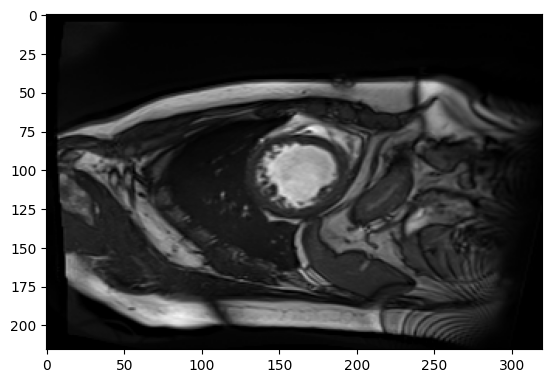

In [6]:
plt.imshow(image, cmap='gray')
plt.show()

# Set Image to Predictor

In [7]:
predictor = SamPredictor(sam)
predictor.set_image(image)

# Make prompt

In [8]:
# Choose one class from the ground truth and sample x random points from it to be the input
def sample_from_class(ground_truth, target_class: int, n_points: int):
    '''
    Generates a list of randomly sampled points from one class of the ground_truth and returns
    them in a readable form for SAM.

    Arguments:
    ground_truth: 2D-array, assigned labels of the original image
    target_class: integer, class to which the sampled points should belong
    n_points: number of points that should be returned

    Returns:
    list of n points belonging to the target_class
    '''
    rows, cols = np.where(ground_truth == target_class)
    points = [[col, row] for row, col in zip(rows, cols)]
    sampled_points = np.array(random.sample(points, n_points))
    return sampled_points

In [9]:
def get_masks(n_points, predictor, ground_truth):
    """This function returns the models masks for a given number of points as prompt.

    Args:
        n_points (int): Number of points that should be given as prompt per class.
        predictor (SAMPredictor): Predictor that has alsready a set image
        ground_truth (np.array): 2D array with the correct class label for each pixel

    Returns:
        np.array: 3D array with the masks (one for each class)
    """
    labels = set(ground_truth.flatten())# see all classes
    labels.remove(0)#remove background label
    n_points = 100
    masks = []
    for i, label in enumerate(labels):
        points = sample_from_class(ground_truth, label, n_points) #sample points from class
        input_labels = np.array([1]*n_points)#label all points as forground
        mask, score, logit = predictor.predict(
                                                                                        point_coords=points,
                                                                                        point_labels=input_labels,
                                                                                        multimask_output=False) #create mask with highest internal score
        masks.append(mask)
    return masks


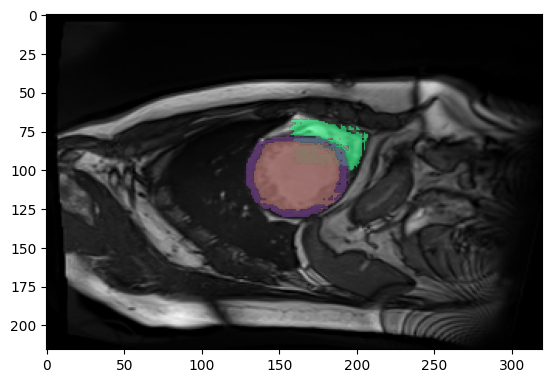

In [10]:
masks = get_masks(50, predictor, ground_truth)
plt.imshow(image)
for mask in masks:
    show_mask(mask, plt.gca(), random_color=True)
plt.axis('on')
plt.show()

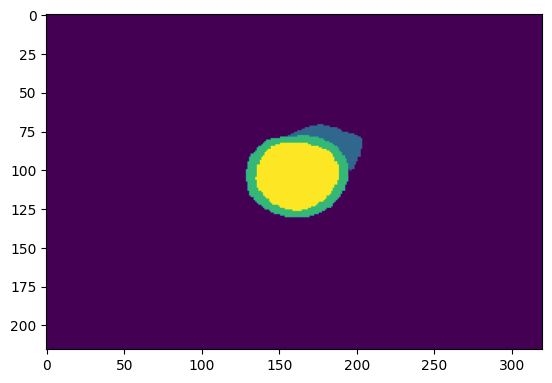

In [11]:
plt.imshow(ground_truth)
plt.show()

# Get probabilities from SAM

In [12]:
def get_logits(n_points, predictor, ground_truth):
    """This function returns the models logits of the masks.

    Args:
        n_points (int): Number of points that should be given as prompt per class.
        predictor (SAMPredictor): Predictor that has alsready a set image
        ground_truth (np.array): 2D array with the correct class label for each pixel

    Returns:
        np.array: 3D array with the logits from the models output of three given prompts
        (one for each class)
    """
    labels = set(ground_truth.flatten())# see all classes
    labels.remove(0)#remove background label
    n_points = 100
    masks = []
    for i, label in enumerate(labels):
        points = sample_from_class(ground_truth, label, n_points) #sample points from class
        input_labels = np.array([1]*n_points)#label all points as forground
        mask, score, logit = predictor.predict(
                                                                                        point_coords=points,
                                                                                        point_labels=input_labels,
                                                                                        multimask_output=False,
                                                                                        return_logits = True) #create mask with highest internal score
        masks.append(mask)
    return masks


In [13]:
logits = get_logits(100, predictor, ground_truth)
#make probabilities out of logits
probabilities = []
for classnr, logit in enumerate(logits):
    #Apply sigmoid function to get probabilities 
    probabilities.append( 1 / (1 + np.exp(-logit[0])))
    

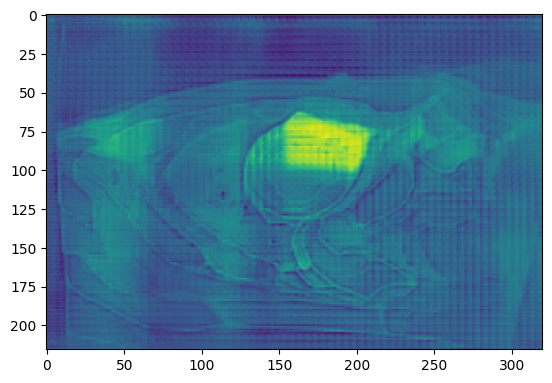

In [25]:
plt.imshow(logits[0][0])
plt.colorbar()

## Ask Jonathan what to do with background! Because we only get the forground probabilities and 3 different numbers for background then 

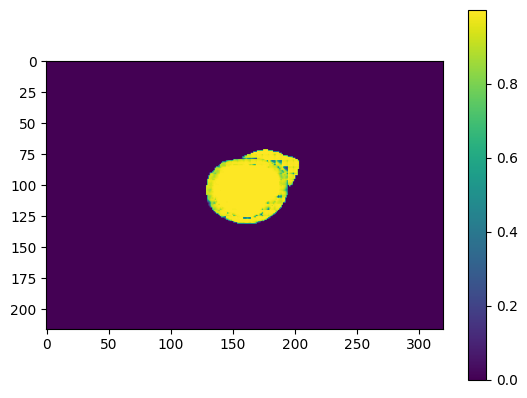

In [34]:
true_probabilities = np.zeros_like(probabilities[0])#initialize an empty array with the same size as the probability arrays
for class_label in range(1,4):#iterate over all foreground classes
    mask = (ground_truth == class_label)
    true_probabilities[mask]= probabilities[class_label-1][mask]
plt.imshow(true_probabilities)
plt.colorbar()

In [35]:
def prob_for_correct(n_points, predictor, ground_truth):
    """Get the probability for each pixel that was calculated for its true class.

    Args:
        n_points (int): Number of points that should be given as prompt per class.
        predictor (SAMPredictor): Predictor that has alsready a set image
        ground_truth (np.array): 2D array with the correct class label for each pixel

    Returns:
        array: 2D array with the same dimensions as the image. Values for pixels represent the probability
        that the model assigned to the pixel beloning to its true class
    """
    logits = get_logits(n_points, predictor, ground_truth)
    #make probabilities out of logits
    probabilities = []
    for classnr, logit in enumerate(logits):
        #Apply sigmoid function to get probabilities 
        probabilities.append( 1 / (1 + np.exp(-logit[0])))
    
    true_probabilities = np.zeros_like(probabilities[0])#initialize an empty array with the same size as the probability arrays
    for class_label in range(1,4):#iterate over all foreground classes
        mask = (ground_truth == class_label)
        true_probabilities[mask]= probabilities[class_label-1][mask]

    return true_probabilities

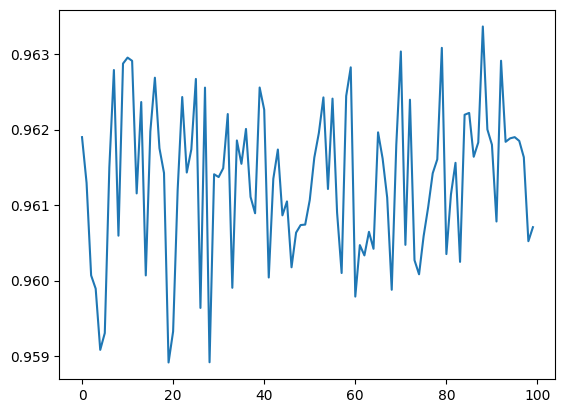

In [43]:
n_points_list = range(100)
sureness_list = []

for n_points in n_points_list:
    #repeat n times to make the result flucluate less due to randomness
    run = []
    for i in range(10):
        probabilities_true = prob_for_correct(n_points, predictor, ground_truth)
        foreground = ground_truth > 0
        sureness = probabilities_true[foreground].mean()
        run.append(sureness)
    sureness_list.append(np.mean(run))

plt.plot(n_points_list,sureness_list)


Something is not right, background probably has to be included!